# PART 1: Problem Definition and Hypothesis

### Predicting Lender Count on Kiva Based on Borrower Demographics and Loan Characteristics

Hypothesis: The expected lender count, influenced by favorable borrower demographics (such as gender, sector, and country), is positively associated with the likelihood of securing contributions from multiple lenders, suggesting that loans perceived as more appealing tend to attract greater community interest and support.




In [55]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor, plot_importance
import shap
import gradio as gr
import joblib
import random



In [56]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")

### PART 2: Data Preparation and Feature Engineering

In [57]:
df_kiva_loans.isnull().sum()

id                         0
funded_amount              0
loan_amount                0
activity                   0
sector                     0
use                     4232
country_code               8
country                    0
region                 56800
currency                   0
partner_id             13507
posted_time                0
disbursed_time          2396
funded_time            48331
term_in_months             0
lender_count               0
tags                  171416
borrower_genders        4221
repayment_interval         0
date                       0
dtype: int64

In [58]:
df_kiva_loans.dropna(inplace=True)

In [59]:
df_kiva_loans.drop_duplicates(inplace=True)

In [60]:
# Converting borrower_genders to string and createing boolean columns for female and male borrowers
df_kiva_loans["borrower_genders"]= df_kiva_loans["borrower_genders"].astype("str")
df_kiva_loans["is_female"] = df_kiva_loans["borrower_genders"].astype("str").apply(lambda x: "female" in x)
df_kiva_loans["is_male"] = df_kiva_loans["borrower_genders"].astype("str").apply(lambda x: len(x) == 4 or (len(x) > 6 and (len(x) % 8) != 6))

In [61]:
# Converting the posted_time, funded_time, and disbursed_time columns to datetime format
df_kiva_loans['posted_time'] = pd.to_datetime(df_kiva_loans['posted_time'])
df_kiva_loans['funded_time'] = pd.to_datetime(df_kiva_loans['funded_time'])
df_kiva_loans['disbursed_time'] = pd.to_datetime(df_kiva_loans['disbursed_time'])

In [62]:
# Calculateing the number of days it takes for a loan to be funded by subtracting posted_time from funded_time
df_kiva_loans['days_to_fund'] = (df_kiva_loans['funded_time'] - df_kiva_loans['posted_time']).dt.days


_______________________________________

In [63]:
# Calculate the interquartile range to identify and remove outliers in the days_to_fund column based on the lower and upper bounds
Q1 = df_kiva_loans['days_to_fund'].quantile(0.25)
Q3 = df_kiva_loans['days_to_fund'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_kiva_loans = df_kiva_loans[(df_kiva_loans['days_to_fund'] >= lower_bound) & (df_kiva_loans['days_to_fund'] <= upper_bound)]

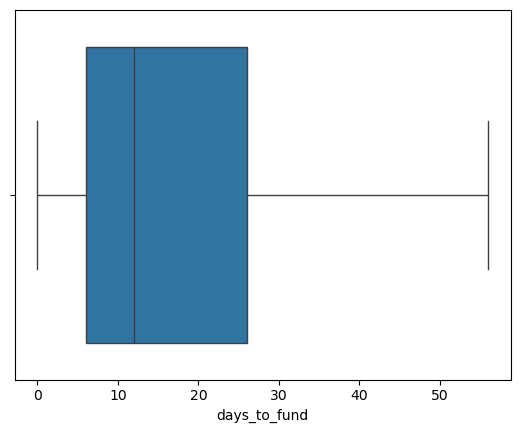

In [64]:
# Boxplot for days to fund
sns.boxplot(x=df_kiva_loans['days_to_fund'])
plt.show()

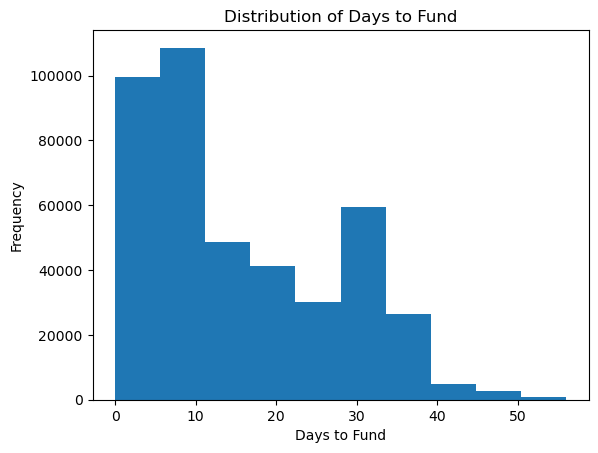

In [65]:
# Create a histogram to visualize the distribution of days it takes for loans to be funded, showing the frequency of each range
plt.hist(df_kiva_loans['days_to_fund'])
plt.xlabel('Days to Fund')
plt.ylabel('Frequency')
plt.title('Distribution of Days to Fund')
plt.show()

In [66]:
# Calculate the interquartile range to identify and remove outliers in the term_in_months column based on the lower and upper bounds
Q1 = df_kiva_loans['term_in_months'].quantile(0.25)
Q3 = df_kiva_loans['term_in_months'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_kiva_loans = df_kiva_loans[(df_kiva_loans['term_in_months'] >= lower_bound) & (df_kiva_loans['term_in_months'] <= upper_bound)]

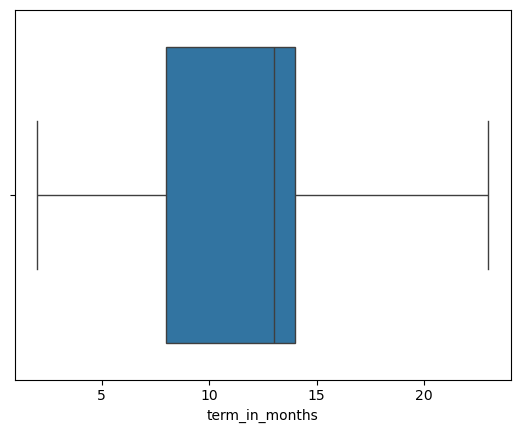

In [67]:
# Boxplot for term in months
sns.boxplot(x=df_kiva_loans['term_in_months'])
plt.show()

In [68]:
# Calculate the interquartile range for loan_amount to identify and remove outliers
Q1 = df_kiva_loans['loan_amount'].quantile(0.25)
Q3 = df_kiva_loans['loan_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_kiva_loans = df_kiva_loans[(df_kiva_loans['loan_amount'] >= lower_bound) & (df_kiva_loans['loan_amount'] <= upper_bound)]

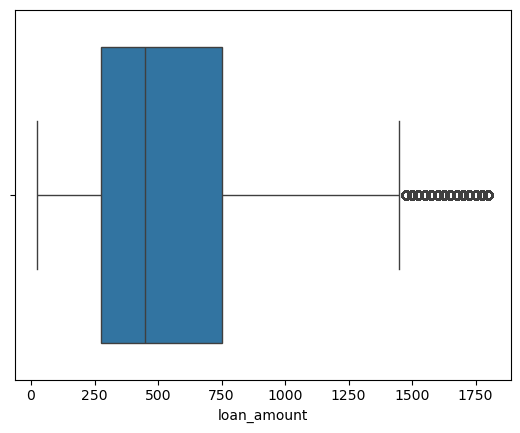

In [69]:
# Display the boxplot without outliers
sns.boxplot(x=df_kiva_loans['loan_amount'])
plt.show()

In [70]:
# Subset to relevant columns that will be used in the model training
selected = df_kiva_loans[['days_to_fund', 'loan_amount', 'is_male', 'is_female', 'sector', 'country', 'lender_count']]

### PART 3: Model Selection and Training:

In [71]:
# Encoding True/False columns
selected['is_male'] = selected['is_male'].astype(int)
selected['is_female'] = selected['is_female'].astype(int)

/var/folders/04/r5r2w3296z124ydph14n15080000gn/T/ipykernel_98452/301430709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['is_male'] = selected['is_male'].astype(int)
/var/folders/04/r5r2w3296z124ydph14n15080000gn/T/ipykernel_98452/301430709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['is_female'] = selected['is_female'].astype(int)


In [72]:
# One-Hot Encoding for categorical columns
df_encoded = pd.get_dummies(selected, columns=['sector', 'country'], drop_first=True)

In [73]:
# Scaling only the input features, not the target variable (lender_count)
scaler = StandardScaler()
df_encoded[['days_to_fund', 'loan_amount']] = scaler.fit_transform(df_encoded[['days_to_fund', 'loan_amount']])

In [74]:
# Define features and target variable for the entire dataset
X = df_encoded.drop('lender_count', axis=1)  # Drop lender_count from features
y = df_encoded['lender_count']  # Set lender_count as the target

# Split the entire dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


First I will try XGBoost model

In [75]:
# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [76]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Print R² score
print("R² score: ", r2)

R² score:  0.806426371955445


In [77]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Print MAE
print("Mean Absolute Error (MAE): ", mae)

Mean Absolute Error (MAE):  3.590734446573099


Good results from XGBoost model. I will try now with Random Forest model

In [78]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 
rf_model.fit(X_train, y_train)

# Predicting values using the model
y_pred_rf = rf_model.predict(X_test)

# Calculate MAE for reference
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Absolute Error (Random Forest): {mae_rf}')

Mean Absolute Error (Random Forest): 3.772909945126979


In [79]:
# Calculate R² score
r2_rf = r2_score(y_test, y_pred_rf)
print(f'R² Score (Random Forest): {r2_rf}')

R² Score (Random Forest): 0.7764792216752406


XGBoost model performed better. XGBoost model will be selected

### PART 4: Hyperparameter Tuning with RandomizedSearchCV

In [80]:
# Parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [4, 5, 6],          
    'learning_rate': [0.1, 0.2],     
    'subsample': [0.7, 0.8],           
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20,  
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Output the best parameters and best score
best_xgb_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=  13.5s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=  13.5s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8; total time=  13.5s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=  17.8s
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7; total time=  18.1s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.7; total time=  10.8s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.7; total time=  10.7s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=  25.9s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=  26.0s
[CV] END learning_rate=0.2, max_depth=6, n_estimators=300, subsample=0.8; total time=  26.1s
[CV] END 

In [81]:
# Using the best estimator from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# Train the model with the best parameters on the full training set
best_xgb_model.fit(X_train, y_train)

# Make predictions using the optimized model
y_pred = best_xgb_model.predict(X_test)

### PART 5: Model Evaluation

In [82]:
# The model's performance on the test set
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print(f"Optimized XGBoost Test MSE: {xgb_mse:.4f}")
print(f"Optimized XGBoost Test MAE: {xgb_mae:.4f}")
print(f"Optimized XGBoost Test R²: {xgb_r2:.4f}")
print(f"Optimized XGBoost Test RMSE: {xgb_rmse:.4f}")

Optimized XGBoost Test MSE: 27.5144
Optimized XGBoost Test MAE: 3.5829
Optimized XGBoost Test R²: 0.8081
Optimized XGBoost Test RMSE: 5.2454


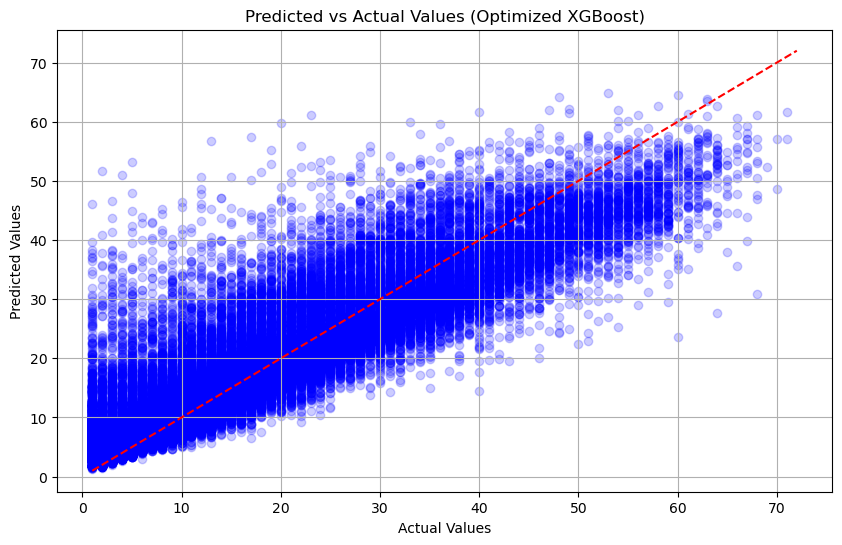

In [93]:
# Create Predicted vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.2)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') 
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Optimized XGBoost)')
plt.grid(True)
plt.show()


The scatter plot and performance metrics indicate that the optimized XGBoost model effectively predicts the number of lenders contributing to loans. The model demonstrates a high level of accuracy, reflected in its significant explanatory power (R²), along with relatively low prediction errors as measured by Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).

While some mismatches exist—particularly for loans with either lower or higher expected lender counts—the overall performance of the model remains robust.

### PART 6: Explainability

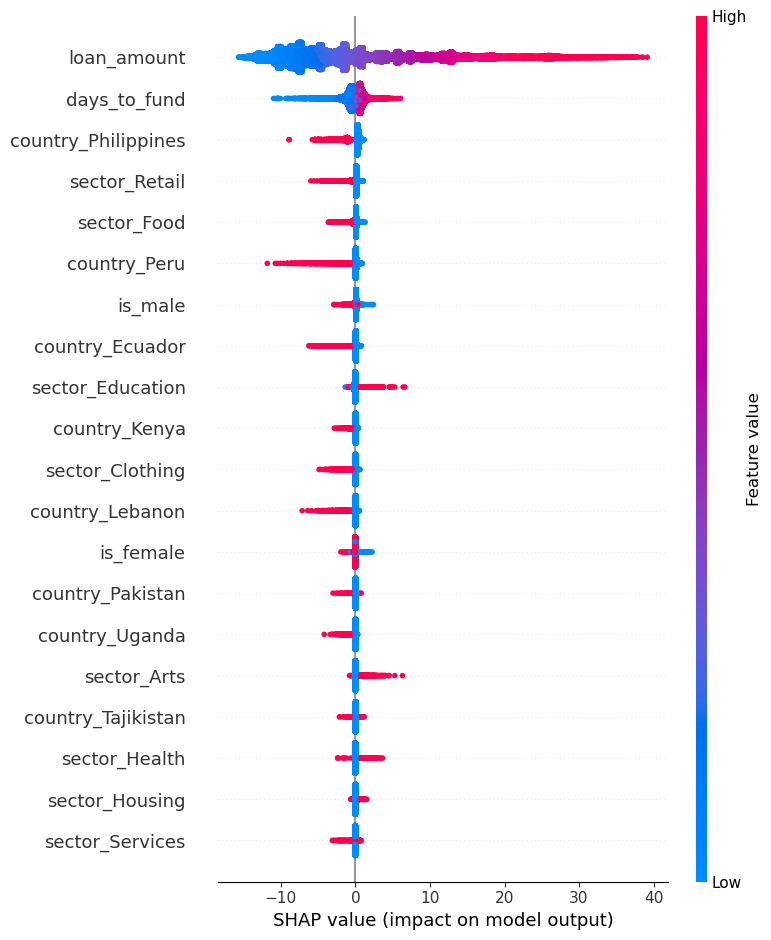

In [84]:
# SHAP TreeExplainer for the best XGBoost model
explainer = shap.TreeExplainer(best_xgb_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values for the first prediction
shap.initjs()  
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])

# Summary plot for SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

<Figure size 1000x800 with 0 Axes>

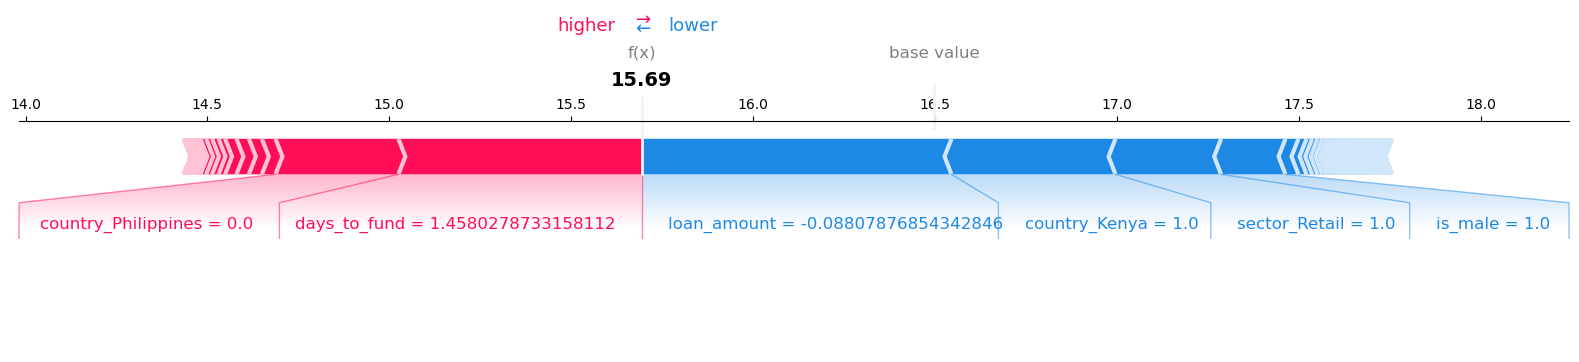

In [85]:
# Random seed for reproducibility
random.seed(50)

# Select a random index from the test set
sample_index = random.choice(range(X_test.shape[0])) 

# Get the corresponding SHAP values for the selected sample
shap_values_sample = shap_values[sample_index]

# Create a new figure for the SHAP force plot
plt.figure(figsize=(10, 8))
shap.initjs()  

# Create a force plot for the selected index
shap.force_plot(explainer.expected_value, shap_values_sample, X_test.iloc[sample_index, :], matplotlib=True, show=True)



<Figure size 1000x800 with 0 Axes>

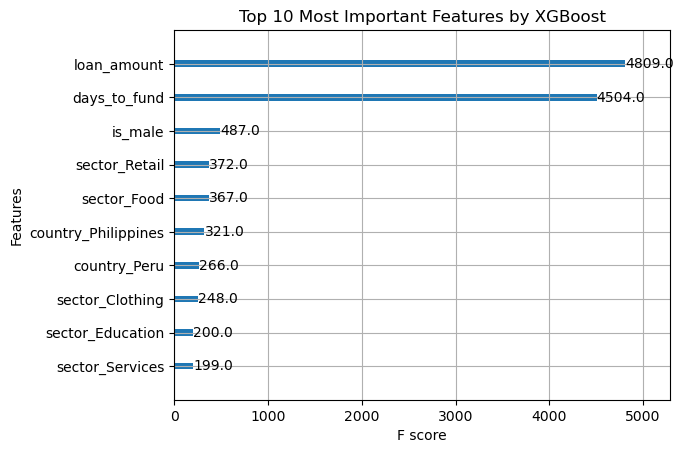

In [86]:
# Plot the feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_model, max_num_features=10, importance_type="weight")
plt.title("Top 10 Most Important Features by XGBoost")
plt.show()

___________________________________________________________________________

Saving the model and scaler so they can be user for the streamlit app

In [87]:
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

In [88]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

___________________________________________________________________________

### PART 7: App Development with gradio

In [92]:
# Load the saved XGBoost model and scaler
best_xgb_model = joblib.load('best_xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

# List of sectors and countries used during model training
sectors = ['Arts', 'Clothing', 'Construction', 'Education', 'Entertainment', 'Food', 'Health', 'Housing',
           'Manufacturing', 'Personal Use', 'Retail', 'Services', 'Transportation', 'Wholesale']

countries = ['Armenia', 'Azerbaijan', 'Belize', 'Benin', 'Bolivia', 'Brazil', 'Burkina Faso', 'Burundi',
             'Cambodia', 'Cameroon', 'China', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador',
             'Egypt', 'El Salvador', 'Georgia', 'Ghana', 'Guatemala', 'Haiti', 'Honduras', 'India',
             'Indonesia', 'Israel', 'Jordan', 'Kenya', 'Kyrgyzstan', 'Lao People\'s Democratic Republic',
             'Lebanon', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mexico', 'Moldova', 'Mongolia',
             'Mozambique', 'Myanmar (Burma)', 'Nepal', 'Nicaragua', 'Nigeria', 'Pakistan', 'Palestine',
             'Panama', 'Paraguay', 'Peru', 'Philippines', 'Rwanda', 'Samoa', 'Senegal', 'Sierra Leone',
             'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Suriname', 'Tajikistan', 'Tanzania',
             'Thailand', 'The Democratic Republic of the Congo', 'Timor-Leste', 'Togo', 'Turkey', 'Uganda',
             'Ukraine', 'United States', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']

# Function to predict lender count instead of loan amount
def predict_lender_count(gender, sector, country, loan_amount, days_to_fund):
    try:
        # Convert gender to binary values
        is_male = 1 if gender.lower() == "male" else 0
        is_female = 1 if gender.lower() == "female" else 0

        # One-hot encode the sector and country
        sector_encoded = [1 if f'sector_{sector}' == f'sector_{s}' else 0 for s in sectors]
        country_encoded = [1 if f'country_{country}' == f'country_{c}' else 0 for c in countries]

        # Combine all features into a single array
        features = np.array([[is_male, is_female, loan_amount, days_to_fund] + sector_encoded + country_encoded])

        # Scale the loan_amount and days_to_fund features
        features[:, 2:4] = scaler.transform(features[:, 2:4])  # Scale both loan_amount and days_to_fund

        # Make the prediction for lender count
        prediction = best_xgb_model.predict(features)

        # Clip negative predictions to 0
        prediction = np.maximum(prediction, 0)

        return f"Predicted Lender Count: {int(prediction[0])}"

    except Exception as e:
        return f"Error: {str(e)}"

# Gradio Interface
iface = gr.Interface(
    fn=predict_lender_count,
    inputs=[
        gr.Radio(choices=["Male", "Female"], label="Gender"),
        gr.Dropdown(choices=sectors, label="Sector"),
        gr.Dropdown(choices=countries, label="Country"),
        gr.Number(label="Loan Amount (USD)"),
        gr.Number(label="Days to Fund")
    ],
    outputs=gr.Textbox(label="Predicted Lender Count"),
    title="Lender Count Predictor",
    description="Input borrower details to predict the expected number of lenders contributing to a loan based on demographics and loan specifics."
)

# Launch the Gradio interface
iface.launch(share=True)  # Use share=True to get a public link


Running on local URL:  http://127.0.0.1:7873
Running on public URL: https://8575126c75d225a57a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
